# W207 Final Project - Facial Keypoint Recognition Baseline
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

In [1]:
# dependencies
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.3.0


### Load Data 

In [2]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


In [3]:
# load data
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


# Need to clean up a few NA's in our set


In [4]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [5]:
# transform all data
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])
# X_tmp = X_tmp / 255.0
# X = np.array([make_array(train.Image[i]) for i in range(len(train))])
X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

#Need to make X_test and Y_test (will we have a Y_test? I think that may be handled in Kaggle)

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')
# print(f'Test examples {numTestExamples}')

Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


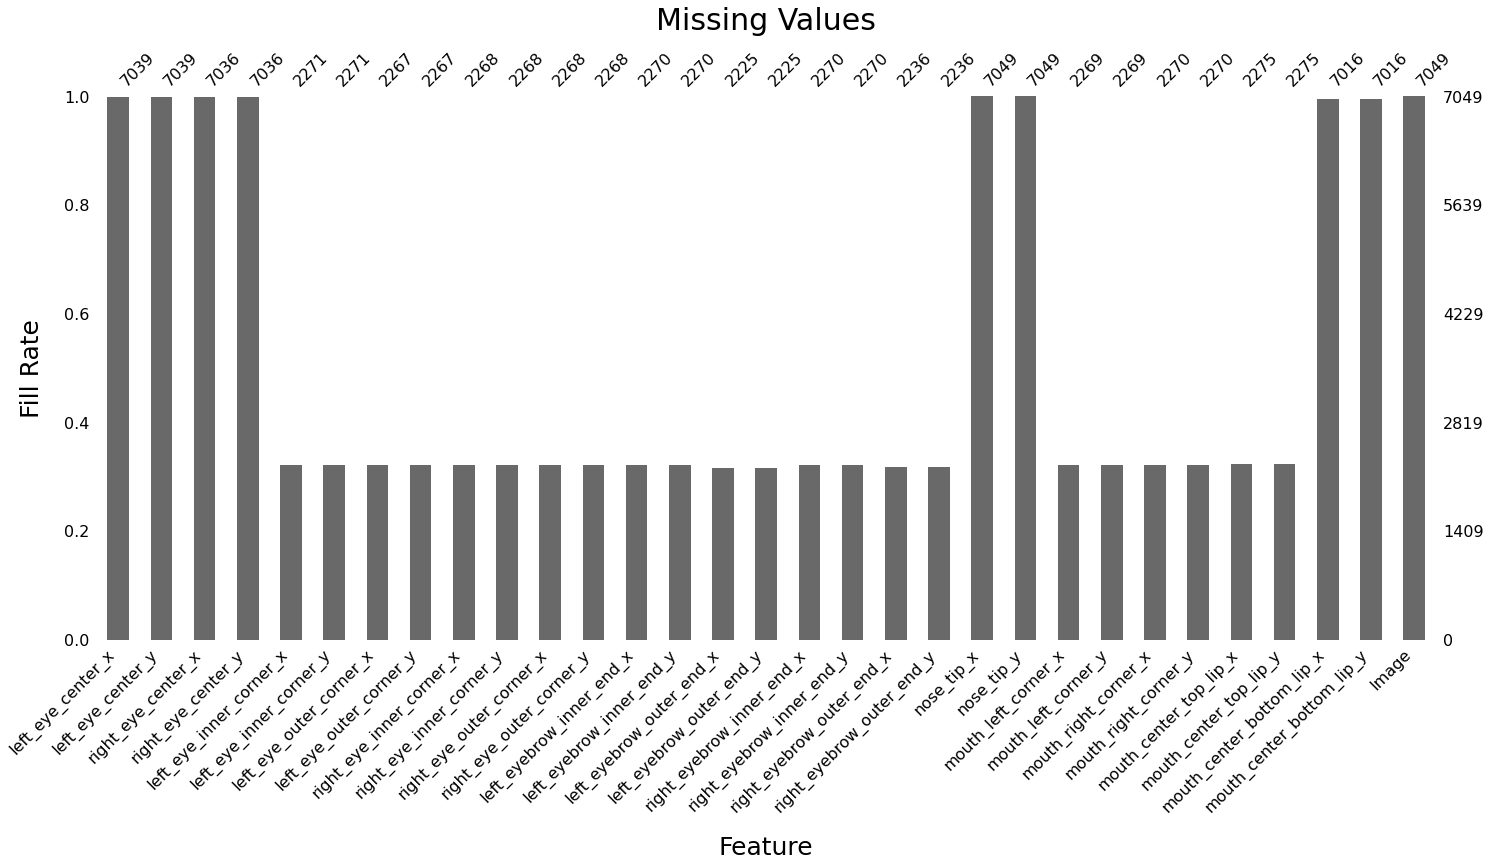

In [6]:
# view missing values
import missingno as msno
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

In [7]:
# EDA see how many na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

## EDA (Removing Missing Values)
We lose 70% of the dataset when removing NAs

In [8]:
#Drop all NAs to have a clean fully labeled dataset
train_noNA = train.dropna(axis=0, how='any', inplace = False)
train_noNA = train_noNA.reset_index(drop=True)
print(len(train))
print(len(train_noNA))

7049
2140


Create arrays for no-NA dataset.

In [9]:
# transform No NaN data
X_noNA = np.array([two_dim(train_noNA.Image[i]) for i in range(len(train_noNA))])
# X_tmp = X_tmp / 255.0
# X = np.array([make_array(train_noNA.Image[i]) for i in range(len(train_noNA))])
X_noNA = X_noNA / 255.0
Y_noNA = np.array([train_noNA.drop('Image', axis = 1).iloc[i] for i in range(len(train_noNA))])

#Need to make X_test and Y_test (will we have a Y_test? I think that may be handled in Kaggle)

shuffle_noNA = np.random.permutation(np.arange(X_noNA.shape[0]))
X_noNA, Y_noNA = X_noNA[shuffle_noNA], Y_noNA[shuffle_noNA]
train_data_noNA, train_labels_noNA = X_noNA[:1200], Y_noNA[:1200]
dev_data_noNA, dev_labels_noNA = X_noNA[1200:], Y_noNA[1200:]
numFeatures_noNA = train_data_noNA[1].size
numTrainExamples_noNA = train_data_noNA.shape[0]
numDevExamples_noNA = dev_data_noNA.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples_noNA}')
print(f'Train features {numFeatures_noNA}')
print(f'Dev examples {numDevExamples_noNA}')
# print(f'Test examples {numTestExamples_noNA}')

Train examples 1200
Train features 9216
Dev examples 940


In [10]:
# #transform dataset into train and dev
# X_noNA = np.array([make_array(train_noNA.Image[i]) for i in range(len(train_noNA))])
# X_noNA = X_noNA / 255.0
# Y_noNA = np.array([train_noNA.drop('Image', axis = 1).iloc[i] for i in range(len(train_noNA))])
# noNA_train_data, noNA_train_labels = X_noNA[:1200], Y_noNA[:1200]
# noNA_dev_data, noNA_dev_labels = X_noNA[1200:], Y_noNA[1200:]

In [11]:
def plot_image(X, y, n, plot_missing = False):
    """
    plot n images with red dots for labels.
    If plot_missing, plot images with missing values (useful for visualizing imputed labels)"""
    if not plot_missing:
        for i in range(n):
            plt.imshow(X[i],cmap='gray')
            #place a point for each of the pictures on the specified coordinates
            for loc in range(0, len(y[i]),2):
                plt.plot(y[i][loc], y[i][loc+1], '*r')
            plt.show()
        
    elif plot_missing:
        for i in train[train['left_eye_outer_corner_y'].isna()].index[:n]:
            plt.imshow(X[i],cmap='gray')
            #place a point for each of the pictures on the specified coordinates
            for loc in range(0, len(y[i]),2):
                plt.plot(y[i][loc], y[i][loc+1], '*r')
            plt.show()

View some images with labeled points.

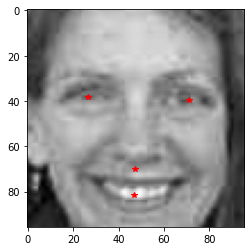

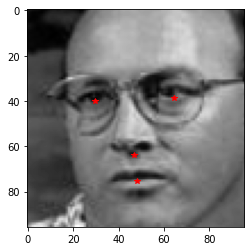

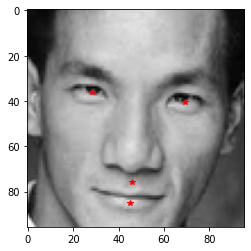

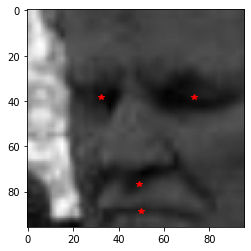

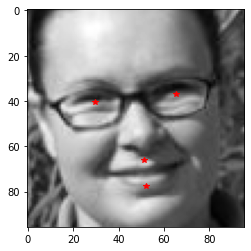

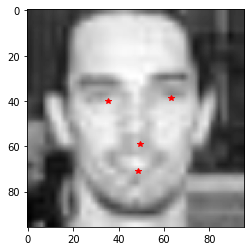

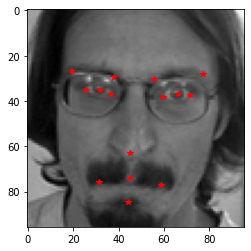

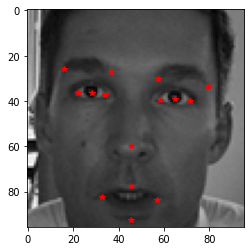

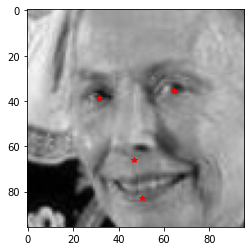

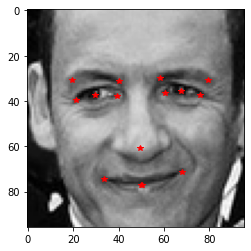

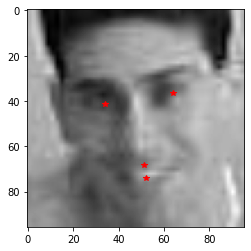

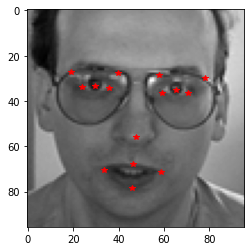

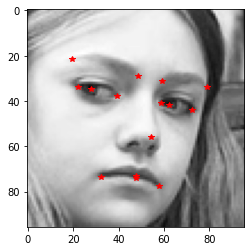

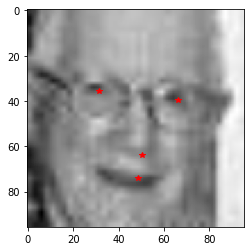

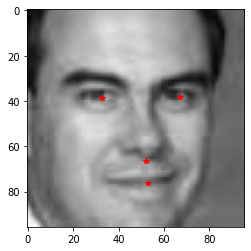

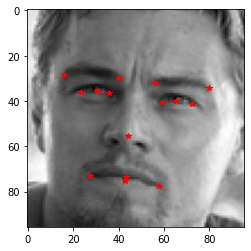

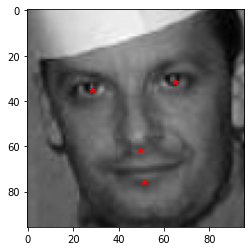

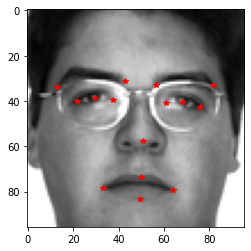

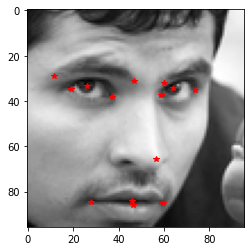

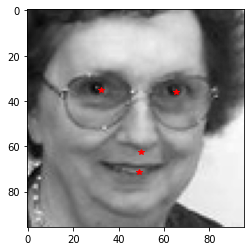

In [12]:
#explore some of the images in the training data
plot_image(train_data, train_labels, 20)

View images without missing values.

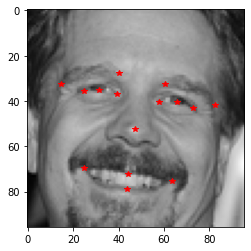

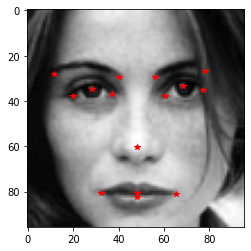

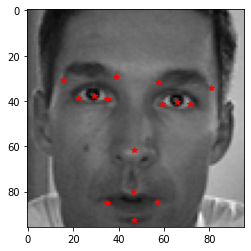

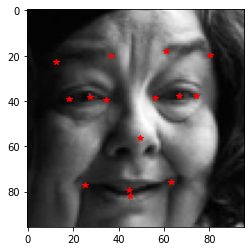

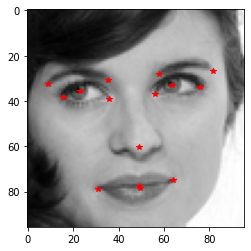

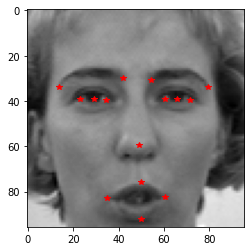

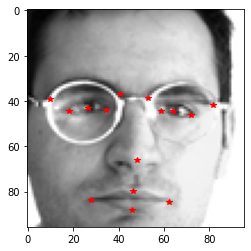

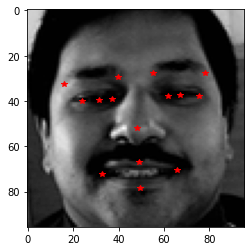

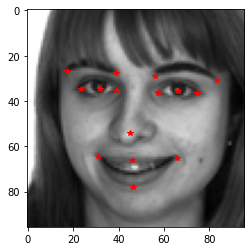

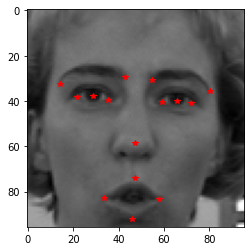

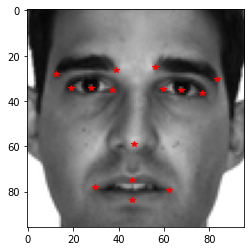

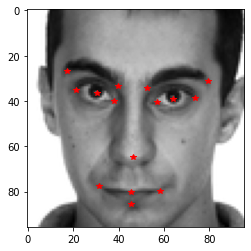

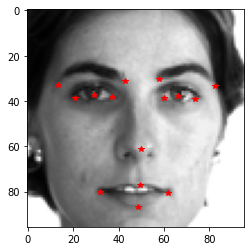

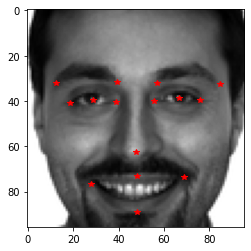

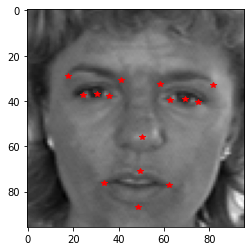

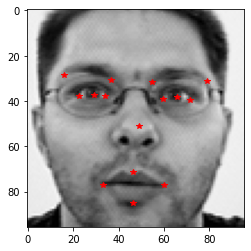

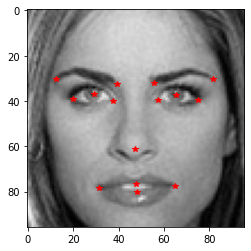

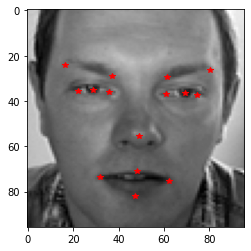

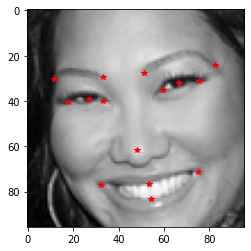

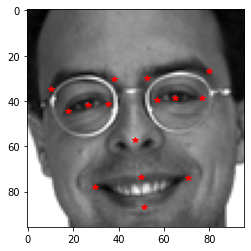

In [13]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
plot_image(train_data_noNA, train_labels_noNA, 20)

Note that images with missing values are not as accurate as fully filled records, even for the values it has filled.

/Users/gregrosen/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


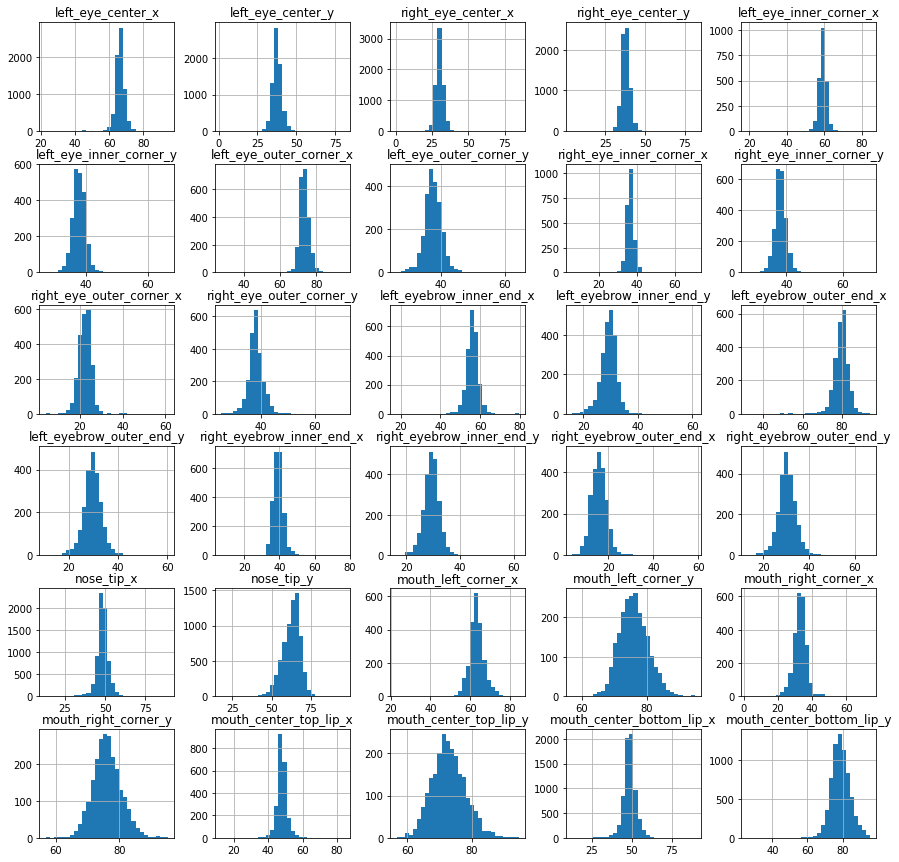

In [14]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))
plt.show()

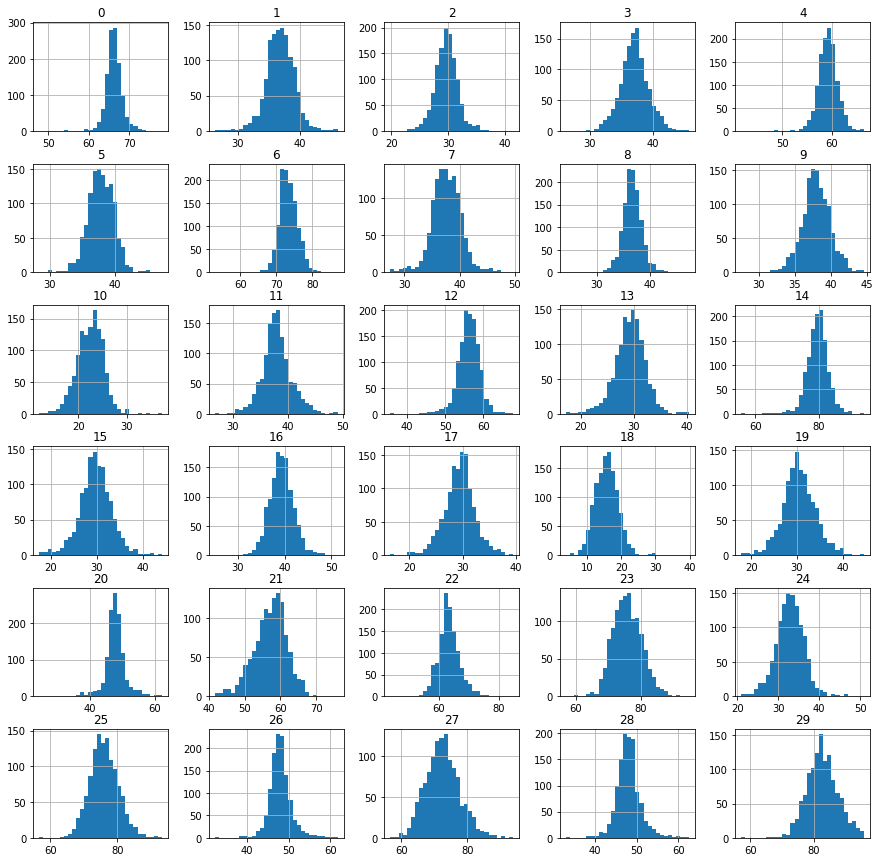

In [15]:
#create df for noNA data to do the same analysis as above
tempdf = pd.DataFrame(train_labels_noNA)
tempdf.hist(bins = 30, figsize=(15,15))
plt.show()

Use the next two cells if you want to explore the dev data to make sure it's clean as well

In [16]:
#tempdf = pd.DataFrame(dev_labels_noNA)

In [17]:
#tempdf.hist(bins = 30, figsize=(15,15))

In [18]:
#Confirm size of the datasets
print(train_data_noNA.shape)
print(train_labels_noNA.shape)
print(dev_data_noNA.shape)
print(dev_labels_noNA.shape)

(1200, 96, 96)
(1200, 30)
(940, 96, 96)
(940, 30)


### Exploratory Data Analysis (Keeping Missing Values)

LEFT_EYE_CENTER_X

count    7039.000000
mean       66.359021
std         3.448233
min        22.763345
25%        65.082895
50%        66.497566
75%        68.024752
max        94.689280
Name: left_eye_center_x, dtype: float64

PLOT:


/Users/gregrosen/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/gregrosen/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


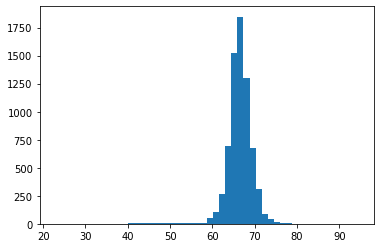


LEFT_EYE_CENTER_Y

count    7039.000000
mean       37.651234
std         3.152926
min         1.616512
25%        35.900451
50%        37.528055
75%        39.258449
max        80.502649
Name: left_eye_center_y, dtype: float64

PLOT:


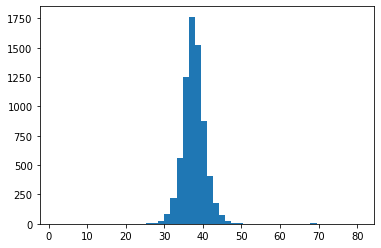


RIGHT_EYE_CENTER_X

count    7036.000000
mean       30.306102
std         3.083230
min         0.686592
25%        28.783339
50%        30.251378
75%        31.768334
max        85.039381
Name: right_eye_center_x, dtype: float64

PLOT:


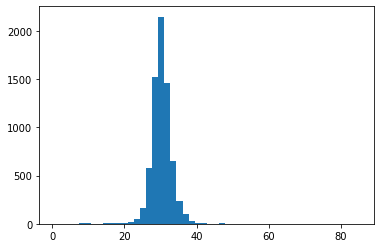


RIGHT_EYE_CENTER_Y

count    7036.000000
mean       37.976943
std         3.033621
min         4.091264
25%        36.327681
50%        37.813273
75%        39.566729
max        81.270911
Name: right_eye_center_y, dtype: float64

PLOT:


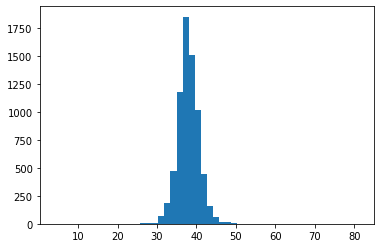


LEFT_EYE_INNER_CORNER_X

count    2271.000000
mean       59.159339
std         2.690354
min        19.064954
25%        58.039339
50%        59.304615
75%        60.519810
max        84.440991
Name: left_eye_inner_corner_x, dtype: float64

PLOT:


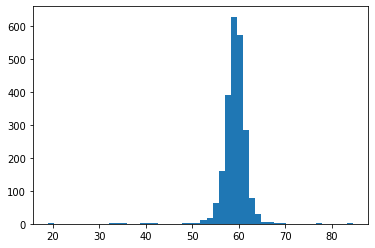


LEFT_EYE_INNER_CORNER_Y

count    2271.000000
mean       37.944752
std         2.307332
min        27.190098
25%        36.626283
50%        37.878040
75%        39.260348
max        66.562559
Name: left_eye_inner_corner_y, dtype: float64

PLOT:


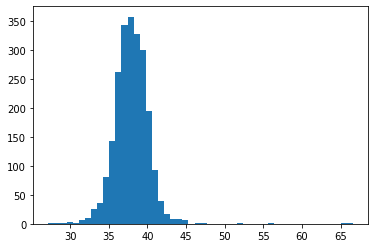


LEFT_EYE_OUTER_CORNER_X

count    2267.000000
mean       73.330478
std         3.405852
min        27.571879
25%        71.716503
50%        73.247824
75%        75.015645
max        95.258090
Name: left_eye_outer_corner_x, dtype: float64

PLOT:


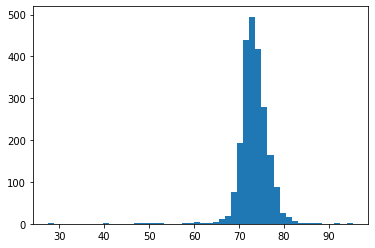


LEFT_EYE_OUTER_CORNER_Y

count    2267.000000
mean       37.707008
std         2.881438
min        26.250023
25%        36.085523
50%        37.639015
75%        39.373489
max        64.618230
Name: left_eye_outer_corner_y, dtype: float64

PLOT:


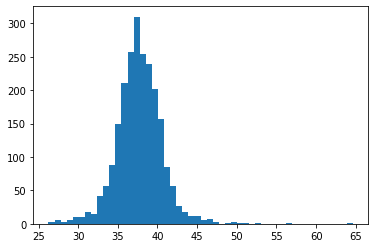


RIGHT_EYE_INNER_CORNER_X

count    2268.000000
mean       36.652607
std         2.350268
min         5.751046
25%        35.506126
50%        36.651562
75%        37.753571
max        70.714966
Name: right_eye_inner_corner_x, dtype: float64

PLOT:


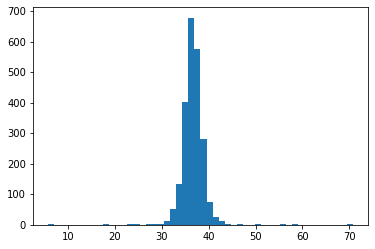


RIGHT_EYE_INNER_CORNER_Y

count    2268.000000
mean       37.989902
std         2.311907
min        26.250023
25%        36.766783
50%        37.944075
75%        39.192917
max        69.808803
Name: right_eye_inner_corner_y, dtype: float64

PLOT:


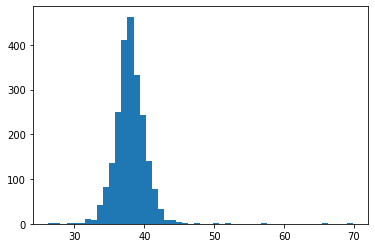


RIGHT_EYE_OUTER_CORNER_X

count    2268.000000
mean       22.384504
std         3.057122
min         3.980117
25%        20.585808
50%        22.535954
75%        24.237701
max        61.428580
Name: right_eye_outer_corner_x, dtype: float64

PLOT:


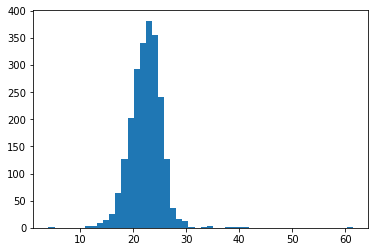


RIGHT_EYE_OUTER_CORNER_Y

count    2268.000000
mean       38.033495
std         2.910368
min        25.123828
25%        36.534382
50%        37.867071
75%        39.415051
max        70.746797
Name: right_eye_outer_corner_y, dtype: float64

PLOT:


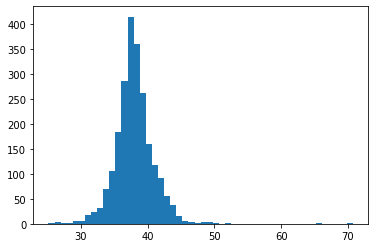


LEFT_EYEBROW_INNER_END_X

count    2270.000000
mean       56.068513
std         3.485485
min        17.888717
25%        54.515587
50%        56.244975
75%        57.946415
max        79.787831
Name: left_eyebrow_inner_end_x, dtype: float64

PLOT:


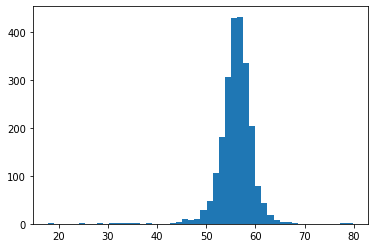


LEFT_EYEBROW_INNER_END_Y

count    2270.000000
mean       29.332678
std         3.078134
min        15.859361
25%        27.617244
50%        29.528872
75%        31.158830
max        60.875896
Name: left_eyebrow_inner_end_y, dtype: float64

PLOT:


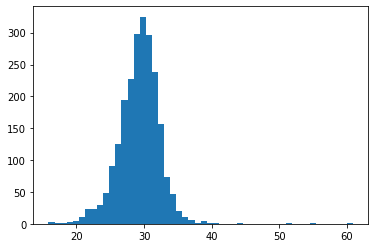


LEFT_EYEBROW_OUTER_END_X

count    2225.000000
mean       79.482826
std         3.986224
min        32.206432
25%        77.673916
50%        79.784229
75%        81.590720
max        94.269957
Name: left_eyebrow_outer_end_x, dtype: float64

PLOT:


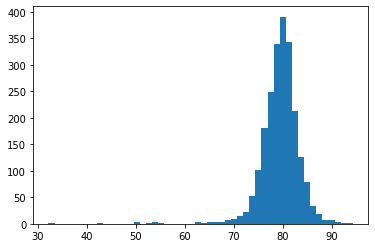


LEFT_EYEBROW_OUTER_END_Y

count    2225.000000
mean       29.734861
std         3.773744
min        10.522325
25%        27.667948
50%        29.773813
75%        31.835621
max        60.500298
Name: left_eyebrow_outer_end_y, dtype: float64

PLOT:


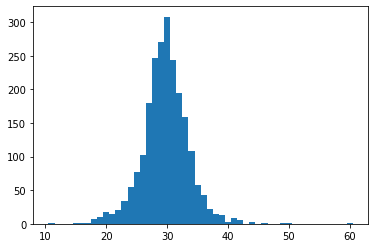


RIGHT_EYEBROW_INNER_END_X

count    2270.000000
mean       39.322137
std         3.209641
min         6.921014
25%        37.552286
50%        39.298848
75%        40.917160
max        76.582388
Name: right_eyebrow_inner_end_x, dtype: float64

PLOT:


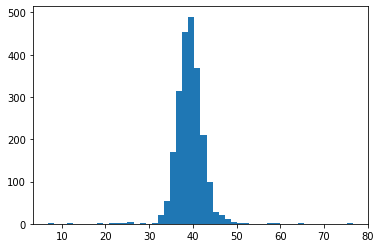


RIGHT_EYEBROW_INNER_END_Y

count    2270.000000
mean       29.502998
std         3.106869
min        16.476000
25%        27.790607
50%        29.569347
75%        31.251664
max        62.083177
Name: right_eyebrow_inner_end_y, dtype: float64

PLOT:


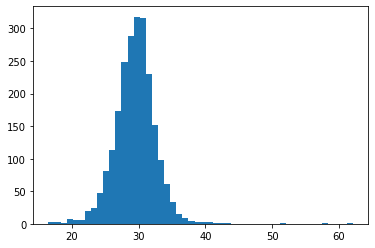


RIGHT_EYEBROW_OUTER_END_X

count    2236.000000
mean       15.871177
std         3.622533
min         3.826243
25%        13.562183
50%        15.785709
75%        17.999040
max        58.418216
Name: right_eyebrow_outer_end_x, dtype: float64

PLOT:


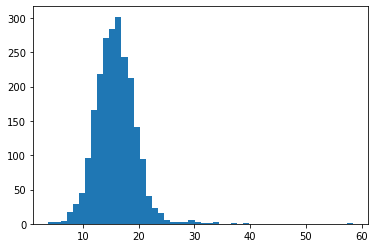


RIGHT_EYEBROW_OUTER_END_Y

count    2236.000000
mean       30.428166
std         3.865772
min        13.224453
25%        28.206046
50%        30.320160
75%        32.654768
max        66.751329
Name: right_eyebrow_outer_end_y, dtype: float64

PLOT:


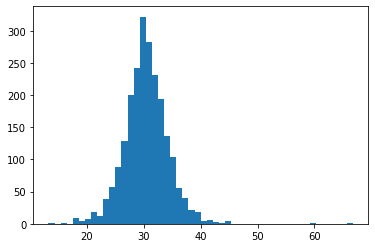


NOSE_TIP_X

count    7049.000000
mean       48.374186
std         4.280038
min        12.944699
25%        46.602370
50%        48.424713
75%        50.330437
max        89.438592
Name: nose_tip_x, dtype: float64

PLOT:


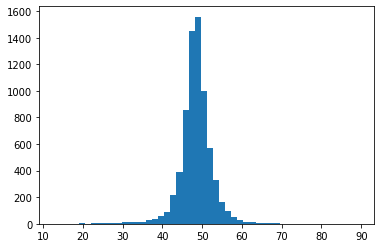


NOSE_TIP_Y

count    7049.000000
mean       62.715884
std         5.720567
min        17.932414
25%        59.292697
50%        63.451421
75%        66.492686
max        95.935644
Name: nose_tip_y, dtype: float64

PLOT:


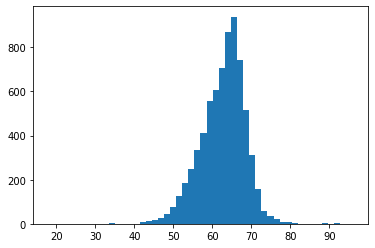


MOUTH_LEFT_CORNER_X

count    2269.000000
mean       63.285735
std         4.079063
min        22.923362
25%        61.257143
50%        63.178286
75%        65.376243
max        84.767123
Name: mouth_left_corner_x, dtype: float64

PLOT:


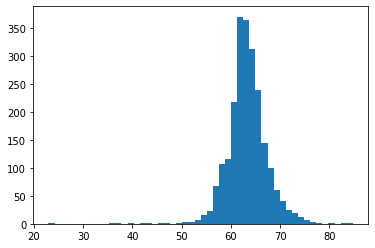


MOUTH_LEFT_CORNER_Y

count    2269.000000
mean       75.970714
std         4.579724
min        57.023258
25%        72.875707
50%        75.778689
75%        78.879123
max        94.673637
Name: mouth_left_corner_y, dtype: float64

PLOT:


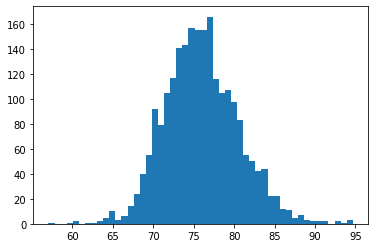


MOUTH_RIGHT_CORNER_X

count    2270.000000
mean       32.900404
std         3.964552
min         2.245766
25%        30.797646
50%        32.982305
75%        35.101302
max        74.017993
Name: mouth_right_corner_x, dtype: float64

PLOT:


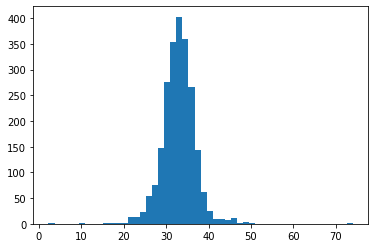


MOUTH_RIGHT_CORNER_Y

count    2270.000000
mean       76.179768
std         4.417814
min        56.690208
25%        73.256472
50%        76.000592
75%        78.956357
max        95.510678
Name: mouth_right_corner_y, dtype: float64

PLOT:


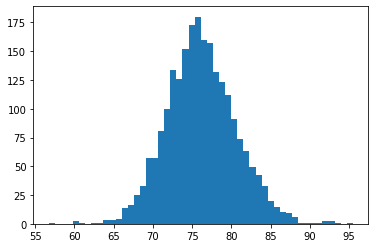


MOUTH_CENTER_TOP_LIP_X

count    2275.000000
mean       47.975412
std         3.323060
min        12.605173
25%        46.494571
50%        47.905490
75%        49.296488
max        83.989082
Name: mouth_center_top_lip_x, dtype: float64

PLOT:


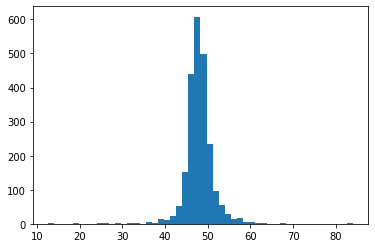


MOUTH_CENTER_TOP_LIP_Y

count    2275.000000
mean       72.919443
std         5.222500
min        56.719043
25%        69.396748
50%        72.605173
75%        76.221644
max        94.548359
Name: mouth_center_top_lip_y, dtype: float64

PLOT:


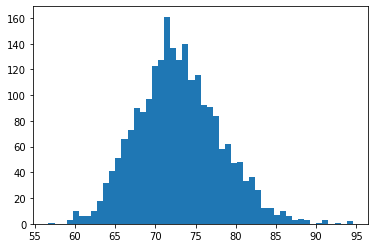


MOUTH_CENTER_BOTTOM_LIP_X

count    7016.000000
mean       48.569472
std         4.269961
min        12.536477
25%        46.573703
50%        48.594978
75%        50.677631
max        89.438592
Name: mouth_center_bottom_lip_x, dtype: float64

PLOT:


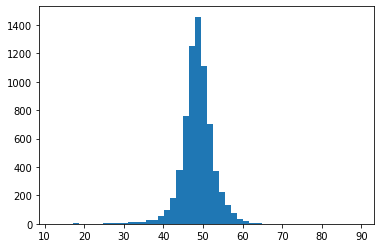


MOUTH_CENTER_BOTTOM_LIP_Y

count    7016.000000
mean       78.970146
std         5.407844
min        25.850503
25%        75.549715
50%        78.696326
75%        82.233993
max        95.808983
Name: mouth_center_bottom_lip_y, dtype: float64

PLOT:


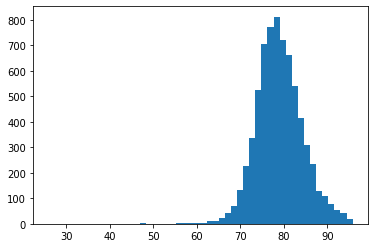

In [19]:
# before imputation
for col in train.drop(columns="Image"):
    print(col.upper())
    print()
    print(train[col].describe())
    print()
    print("PLOT:")
    plt.hist(col, data = train, bins = 50)
    plt.show()
    print()

### Forward Fill Missing Value Imputation

In [20]:
# impute missing values
train_ffill = train.fillna(method = "ffill")

# transform Y for ffill in same way as non-ffill data (create for ffill imputation visuals)
Y_ffill = np.array([train_ffill.drop('Image', axis = 1).iloc[i] for i in range(len(train_ffill))])
Y_ffill = Y_ffill[shuffle]

# transform train and dev labels for model
train_labels_ffill = Y_ffill[:5000]
dev_labels_ffill = Y_ffill[5000:]

LEFT_EYE_CENTER_X

count    7049.000000
mean       66.358588
std         3.447098
min        22.763345
25%        65.082643
50%        66.493907
75%        68.024628
max        94.689280
Name: left_eye_center_x, dtype: float64

PLOT:


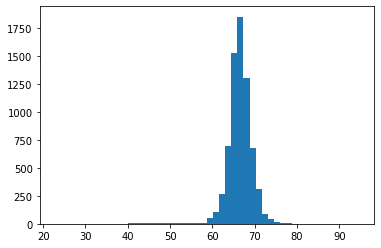


LEFT_EYE_CENTER_Y

count    7049.000000
mean       37.649140
std         3.152072
min         1.616512
25%        35.900605
50%        37.526919
75%        39.254400
max        80.502649
Name: left_eye_center_y, dtype: float64

PLOT:


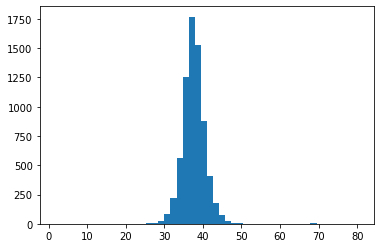


RIGHT_EYE_CENTER_X

count    7049.000000
mean       30.306631
std         3.083087
min         0.686592
25%        28.782316
50%        30.253135
75%        31.768407
max        85.039381
Name: right_eye_center_x, dtype: float64

PLOT:


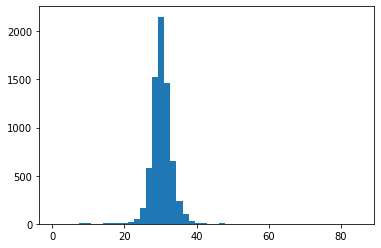


RIGHT_EYE_CENTER_Y

count    7049.000000
mean       37.975901
std         3.032590
min         4.091264
25%        36.327178
50%        37.812736
75%        39.565928
max        81.270911
Name: right_eye_center_y, dtype: float64

PLOT:


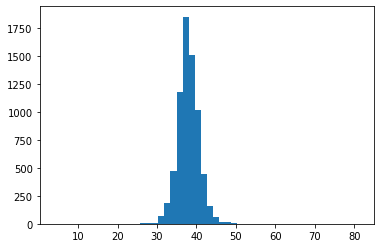


LEFT_EYE_INNER_CORNER_X

count    7049.000000
mean       59.224060
std         1.537961
min        19.064954
25%        59.255347
50%        59.255347
75%        59.255347
max        84.440991
Name: left_eye_inner_corner_x, dtype: float64

PLOT:


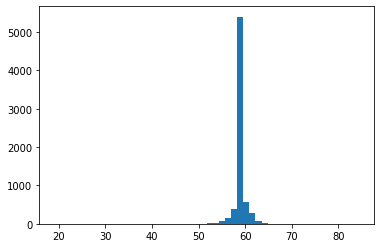


LEFT_EYE_INNER_CORNER_Y

count    7049.000000
mean       36.675731
std         1.581946
min        27.190098
25%        36.065143
50%        36.065143
75%        36.499692
max        66.562559
Name: left_eye_inner_corner_y, dtype: float64

PLOT:


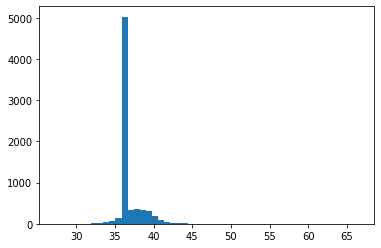


LEFT_EYE_OUTER_CORNER_X

count    7049.000000
mean       73.746775
std         1.961901
min        27.571879
25%        73.942694
50%        73.942694
75%        73.942694
max        95.258090
Name: left_eye_outer_corner_x, dtype: float64

PLOT:


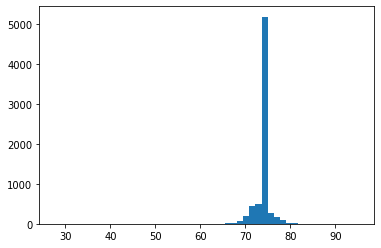


LEFT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       35.619961
std         2.184829
min        26.250023
25%        34.624653
50%        34.624653
75%        35.902613
max        64.618230
Name: left_eye_outer_corner_y, dtype: float64

PLOT:


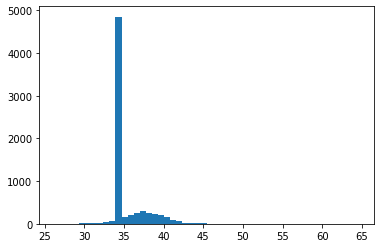


RIGHT_EYE_INNER_CORNER_X

count    7049.000000
mean       37.214171
std         1.393110
min         5.751046
25%        37.478531
50%        37.478531
75%        37.478531
max        70.714966
Name: right_eye_inner_corner_x, dtype: float64

PLOT:


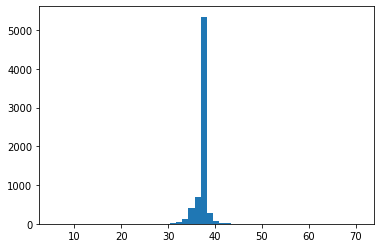


RIGHT_EYE_INNER_CORNER_Y

count    7049.000000
mean       38.942849
std         1.470456
min        26.250023
25%        39.355685
50%        39.398041
75%        39.398041
max        69.808803
Name: right_eye_inner_corner_y, dtype: float64

PLOT:


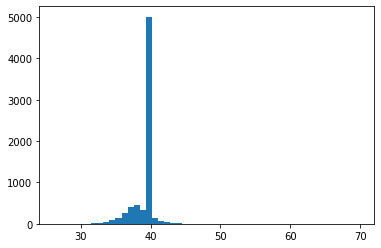


RIGHT_EYE_OUTER_CORNER_X

count    7049.000000
mean       22.162446
std         1.747700
min         3.980117
25%        22.056816
50%        22.056816
75%        22.056816
max        61.428580
Name: right_eye_outer_corner_x, dtype: float64

PLOT:


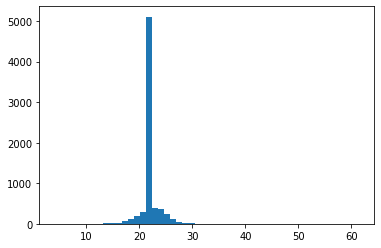


RIGHT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       39.588348
std         1.972413
min        25.123828
25%        39.645538
50%        40.330122
75%        40.330122
max        70.746797
Name: right_eye_outer_corner_y, dtype: float64

PLOT:


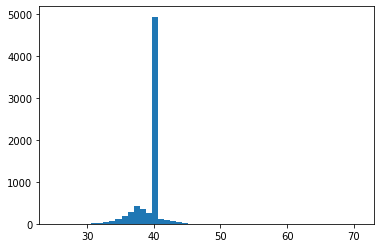


LEFT_EYEBROW_INNER_END_X

count    7049.000000
mean       54.194620
std         2.370622
min        17.888717
25%        53.299787
50%        53.299787
75%        54.311385
max        79.787831
Name: left_eyebrow_inner_end_x, dtype: float64

PLOT:


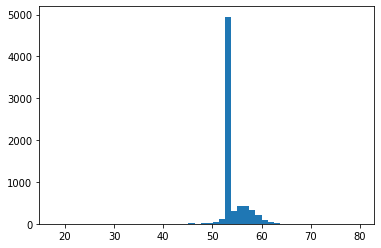


LEFT_EYEBROW_INNER_END_Y

count    7049.000000
mean       29.774418
std         1.777130
min        15.859361
25%        29.987657
50%        29.987657
75%        29.987657
max        60.875896
Name: left_eyebrow_inner_end_y, dtype: float64

PLOT:


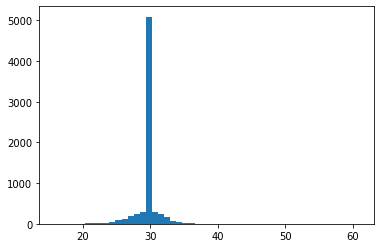


LEFT_EYEBROW_OUTER_END_X

count    7049.000000
mean       80.468907
std         2.398672
min        32.206432
25%        80.947787
50%        80.947787
75%        80.947787
max        94.269957
Name: left_eyebrow_outer_end_x, dtype: float64

PLOT:


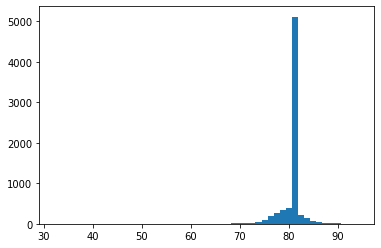


LEFT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       28.534791
std         2.314226
min        10.522325
25%        27.977535
50%        27.977535
75%        27.977535
max        60.500298
Name: left_eyebrow_outer_end_y, dtype: float64

PLOT:


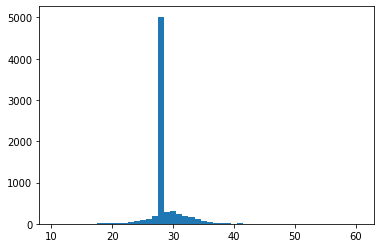


RIGHT_EYEBROW_INNER_END_X

count    7049.000000
mean       38.954169
std         1.846922
min         6.921014
25%        38.779298
50%        38.779298
75%        38.779298
max        76.582388
Name: right_eyebrow_inner_end_x, dtype: float64

PLOT:


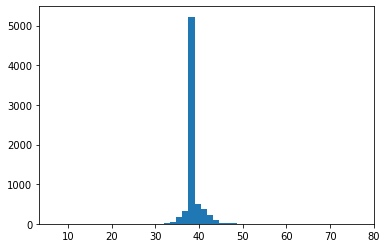


RIGHT_EYEBROW_INNER_END_Y

count    7049.000000
mean       32.070739
std         2.507250
min        16.476000
25%        31.430071
50%        33.302596
75%        33.302596
max        62.083177
Name: right_eyebrow_inner_end_y, dtype: float64

PLOT:


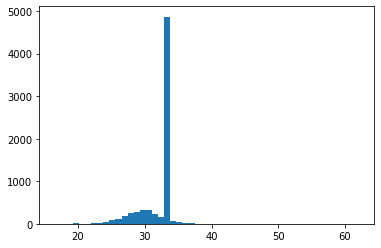


RIGHT_EYEBROW_OUTER_END_X

count    7049.000000
mean       15.138279
std         2.140417
min         3.826243
25%        14.798890
50%        14.798890
75%        14.798890
max        58.418216
Name: right_eyebrow_outer_end_x, dtype: float64

PLOT:


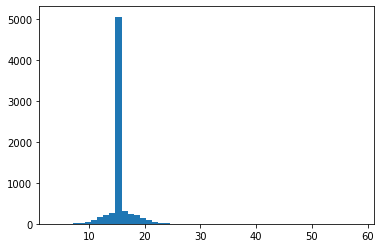


RIGHT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       34.188305
std         3.407792
min        13.224453
25%        32.994798
50%        35.982760
75%        35.982760
max        66.751329
Name: right_eyebrow_outer_end_y, dtype: float64

PLOT:


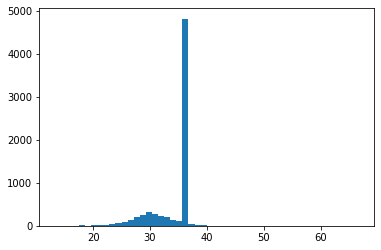


NOSE_TIP_X

count    7049.000000
mean       48.374186
std         4.280038
min        12.944699
25%        46.602370
50%        48.424713
75%        50.330437
max        89.438592
Name: nose_tip_x, dtype: float64

PLOT:


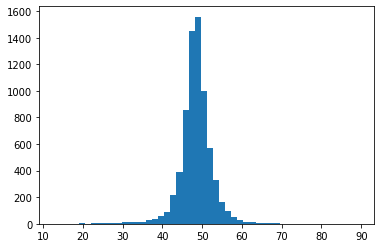


NOSE_TIP_Y

count    7049.000000
mean       62.715884
std         5.720567
min        17.932414
25%        59.292697
50%        63.451421
75%        66.492686
max        95.935644
Name: nose_tip_y, dtype: float64

PLOT:


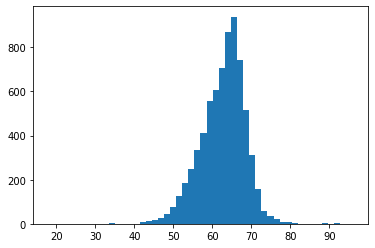


MOUTH_LEFT_CORNER_X

count    7049.000000
mean       69.586932
std         4.932241
min        22.923362
25%        65.731401
50%        72.600433
75%        72.600433
max        84.767123
Name: mouth_left_corner_x, dtype: float64

PLOT:


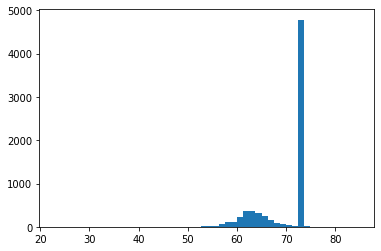


MOUTH_LEFT_CORNER_Y

count    7049.000000
mean       73.195985
std         3.242852
min        57.023258
25%        71.862041
50%        71.862041
75%        72.591200
max        94.673637
Name: mouth_left_corner_y, dtype: float64

PLOT:


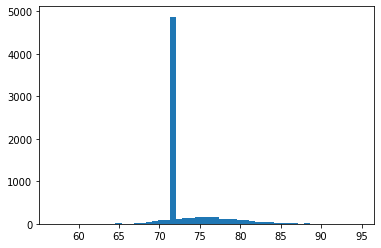


MOUTH_RIGHT_CORNER_X

count    7049.000000
mean       33.799680
std         2.350229
min         2.245766
25%        34.232759
50%        34.232759
75%        34.232759
max        74.017993
Name: mouth_right_corner_x, dtype: float64

PLOT:


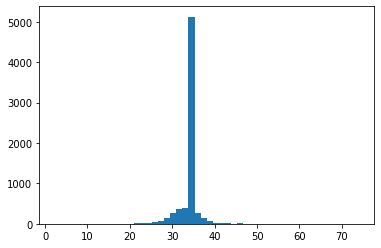


MOUTH_RIGHT_CORNER_Y

count    7049.000000
mean       76.964546
std         2.578721
min        56.690208
25%        77.339429
50%        77.339429
75%        77.339429
max        95.510678
Name: mouth_right_corner_y, dtype: float64

PLOT:


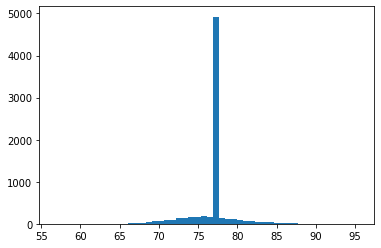


MOUTH_CENTER_TOP_LIP_X

count    7049.000000
mean       50.425299
std         2.543271
min        12.605173
25%        49.471414
50%        51.599453
75%        51.599453
max        83.989082
Name: mouth_center_top_lip_x, dtype: float64

PLOT:


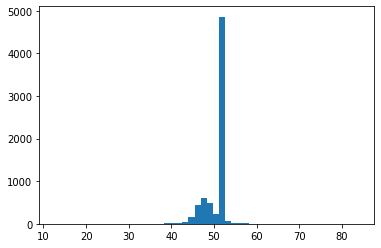


MOUTH_CENTER_TOP_LIP_Y

count    7049.000000
mean       74.982529
std         3.294983
min        56.719043
25%        75.963592
50%        75.963592
75%        75.963592
max        94.548359
Name: mouth_center_top_lip_y, dtype: float64

PLOT:


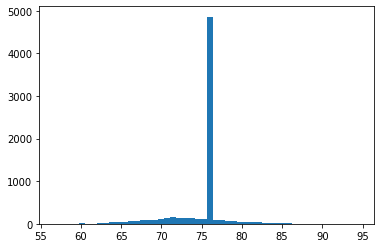


MOUTH_CENTER_BOTTOM_LIP_X

count    7049.000000
mean       48.565976
std         4.266848
min        12.536477
25%        46.571821
50%        48.588662
75%        50.676559
max        89.438592
Name: mouth_center_bottom_lip_x, dtype: float64

PLOT:


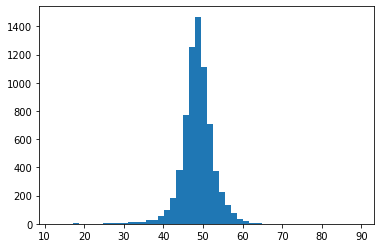


MOUTH_CENTER_BOTTOM_LIP_Y

count    7049.000000
mean       78.979256
std         5.406621
min        25.850503
25%        75.553726
50%        78.704640
75%        82.236528
max        95.808983
Name: mouth_center_bottom_lip_y, dtype: float64

PLOT:


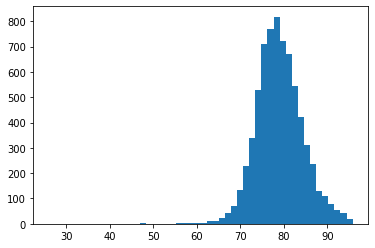

In [21]:
# after ffill imputation (run forward fill cell in Impute Missing Values section below)
for col in train_ffill.drop(columns = "Image"):
    print(col.upper())
    print()
    print(train_ffill[col].describe())
    print()
    print("PLOT:")
    plt.hist(col, data = train_ffill, bins = 50)
    plt.show()
    print()

### KNN Missing Value Imputation

In [22]:
# scale data (optimal for KNN distances)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop(columns = "Image"))
train_labels_scaled = scaler.fit_transform(train_labels)
# mini_train_labels_scaled = scaler.fit_transform(mini_train_labels)
dev_labels_scaled = scaler.fit_transform(dev_labels)

# KNN Imputation (scaled) (K = 5)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train_knn_scaled = imputer.fit_transform(train_scaled)
train_labels_knn_scaled = imputer.fit_transform(train_labels_scaled)
# mini_train_labels_knn_scaled = imputer.fit_transform(mini_train_labels_scaled)
dev_labels_knn_scaled = imputer.fit_transform(dev_labels_scaled)

### removing in lieu of scaled KNN
# # KNN Imputation (no scale) (K = 5)
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# train_knn = imputer.fit_transform(train.drop(columns="Image"))
# train_labels_knn = imputer.fit_transform(train_labels)
# # mini_train_labels_knn = imputer.fit_transform(mini_train_labels)
# dev_labels_knn = imputer.fit_transform(dev_labels)

# Inverse transform after imputation for viewing performance on images
train_knn_scaled_inverse = scaler.inverse_transform(train_knn_scaled)
train_labels_knn_scaled_inverse = scaler.inverse_transform(train_labels_knn_scaled)
# mini_train_labels_knn_scaled_inverse = scaler.inverse_transform(mini_train_labels_knn_scaled)
dev_labels_knn_scaled_inverse = scaler.inverse_transform(dev_labels_knn_scaled)

LEFT_EYE_CENTER_X

count    7049.000000
mean       66.373958
std         3.340756
min        24.270022
25%        65.142382
50%        66.508056
75%        67.984971
max        93.738255
Name: left_eye_center_x, dtype: float64

PLOT:


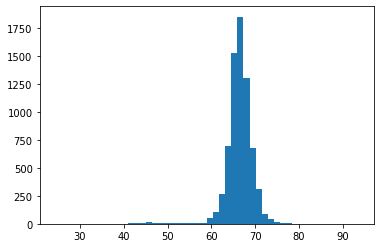


LEFT_EYE_CENTER_Y

count    7049.000000
mean       37.633199
std         3.097318
min         2.225101
25%        35.912103
50%        37.512098
75%        39.215267
max        79.737360
Name: left_eye_center_y, dtype: float64

PLOT:


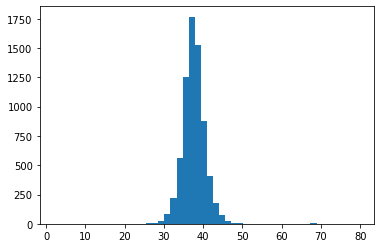


RIGHT_EYE_CENTER_X

count    7049.000000
mean       30.280554
std         3.030007
min         1.230619
25%        28.789754
50%        30.229420
75%        31.717335
max        83.968372
Name: right_eye_center_x, dtype: float64

PLOT:


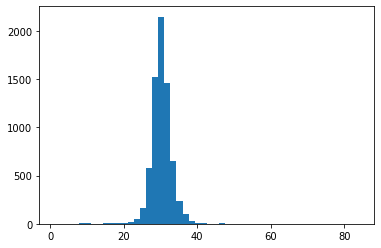


RIGHT_EYE_CENTER_Y

count    7049.000000
mean       38.014188
std         2.928587
min         5.306032
25%        36.422333
50%        37.857333
75%        39.547748
max        79.805087
Name: right_eye_center_y, dtype: float64

PLOT:


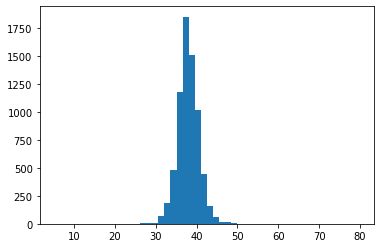


LEFT_EYE_INNER_CORNER_X

count    7049.000000
mean       59.021909
std         2.192215
min        22.908803
25%        58.400723
50%        59.260743
75%        60.012746
max        81.954460
Name: left_eye_inner_corner_x, dtype: float64

PLOT:


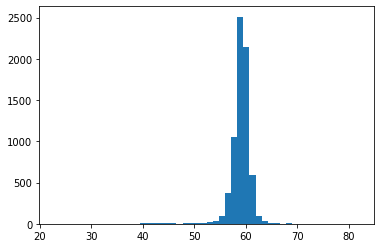


LEFT_EYE_INNER_CORNER_Y

count    7049.000000
mean       38.382120
std         1.813997
min        27.806219
25%        37.373252
50%        38.403983
75%        39.369736
max        64.766536
Name: left_eye_inner_corner_y, dtype: float64

PLOT:


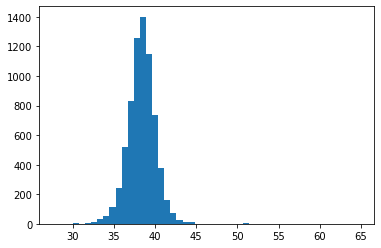


LEFT_EYE_OUTER_CORNER_X

count    7049.000000
mean       73.506777
std         2.875675
min        30.657607
25%        72.341172
50%        73.643014
75%        74.950412
max        93.927682
Name: left_eye_outer_corner_x, dtype: float64

PLOT:


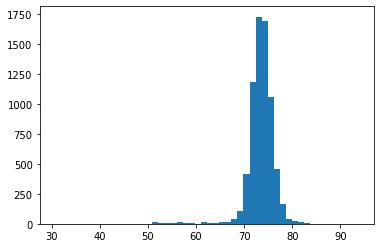


LEFT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       37.908780
std         2.782565
min        25.746097
25%        36.212623
50%        37.922894
75%        39.569616
max        65.523684
Name: left_eye_outer_corner_y, dtype: float64

PLOT:


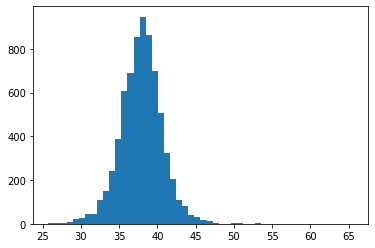


RIGHT_EYE_INNER_CORNER_X

count    7049.000000
mean       37.016350
std         1.995291
min         6.194290
25%        36.283013
50%        37.117963
75%        37.920288
max        70.141293
Name: right_eye_inner_corner_x, dtype: float64

PLOT:


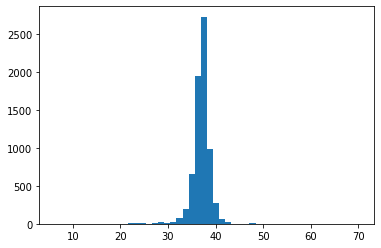


RIGHT_EYE_INNER_CORNER_Y

count    7049.000000
mean       38.545302
std         1.737513
min        27.212715
25%        37.622746
50%        38.546913
75%        39.555236
max        67.214831
Name: right_eye_inner_corner_y, dtype: float64

PLOT:


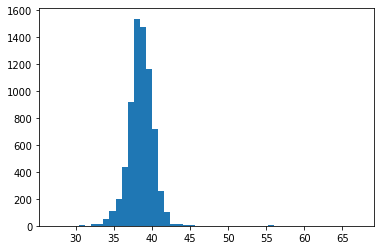


RIGHT_EYE_OUTER_CORNER_X

count    7049.000000
mean       22.556872
std         2.620779
min         4.002879
25%        20.945230
50%        22.733420
75%        24.159061
max        61.154364
Name: right_eye_outer_corner_x, dtype: float64

PLOT:


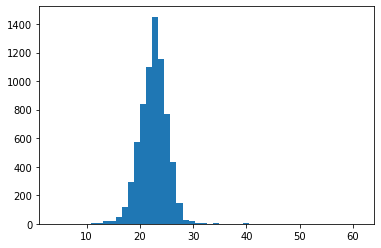


RIGHT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       38.459170
std         2.523592
min        25.170664
25%        37.166956
50%        38.395897
75%        39.855391
max        70.647153
Name: right_eye_outer_corner_y, dtype: float64

PLOT:


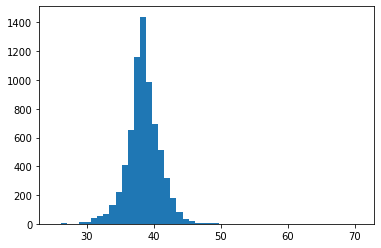


LEFT_EYEBROW_INNER_END_X

count    7049.000000
mean       56.150880
std         2.893462
min        20.538209
25%        55.059895
50%        56.501676
75%        57.626111
max        78.175266
Name: left_eyebrow_inner_end_x, dtype: float64

PLOT:


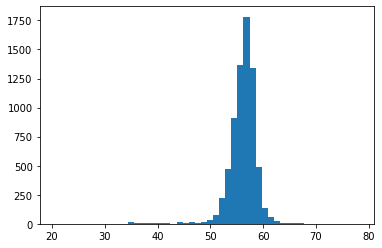


LEFT_EYEBROW_INNER_END_Y

count    7049.000000
mean       30.087596
std         2.205441
min        16.756524
25%        29.016474
50%        30.197765
75%        31.299021
max        58.432723
Name: left_eyebrow_inner_end_y, dtype: float64

PLOT:


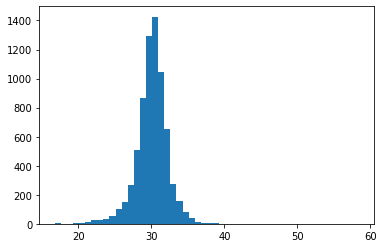


LEFT_EYEBROW_OUTER_END_X

count    7049.000000
mean       79.448722
std         3.173989
min        38.117478
25%        78.225757
50%        79.650577
75%        81.058630
max        92.672310
Name: left_eyebrow_outer_end_x, dtype: float64

PLOT:


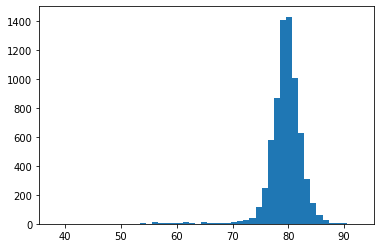


LEFT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       29.822585
std         3.385788
min         9.633608
25%        27.930257
50%        29.947635
75%        31.679625
max        61.949570
Name: left_eyebrow_outer_end_y, dtype: float64

PLOT:


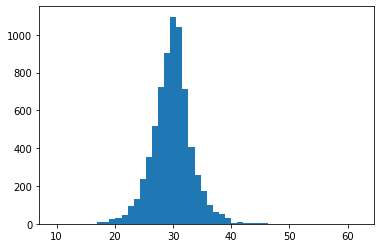


RIGHT_EYEBROW_INNER_END_X

count    7049.000000
mean       39.604743
std         2.654644
min         7.129580
25%        38.359946
50%        39.662794
75%        40.925196
max        76.214852
Name: right_eyebrow_inner_end_x, dtype: float64

PLOT:


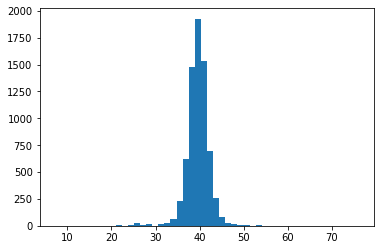


RIGHT_EYEBROW_INNER_END_Y

count    7049.000000
mean       30.512454
std         2.313389
min        17.182670
25%        29.273838
50%        30.650312
75%        31.885552
max        60.259897
Name: right_eyebrow_inner_end_y, dtype: float64

PLOT:


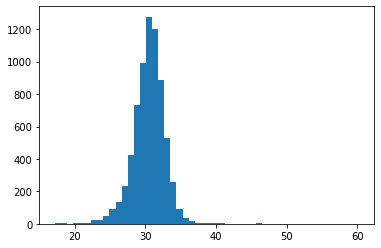


RIGHT_EYEBROW_OUTER_END_X

count    7049.000000
mean       16.042447
std         2.892733
min         4.343694
25%        14.103575
50%        16.184397
75%        17.882843
max        55.758707
Name: right_eyebrow_outer_end_x, dtype: float64

PLOT:


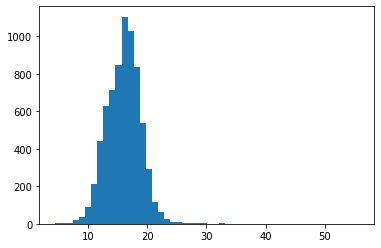


RIGHT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       30.810256
std         3.325771
min        13.005379
25%        28.911134
50%        30.636533
75%        32.878335
max        67.214594
Name: right_eyebrow_outer_end_y, dtype: float64

PLOT:


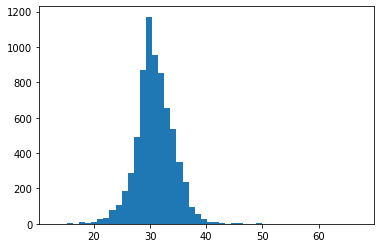


NOSE_TIP_X

count    7049.000000
mean       48.379827
std         4.248151
min        13.214299
25%        46.621211
50%        48.429977
75%        50.321503
max        89.138291
Name: nose_tip_x, dtype: float64

PLOT:


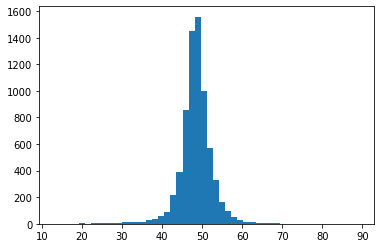


NOSE_TIP_Y

count    7049.000000
mean       62.790983
std         5.670604
min        18.398648
25%        59.397694
50%        63.520096
75%        66.534799
max        95.720606
Name: nose_tip_y, dtype: float64

PLOT:


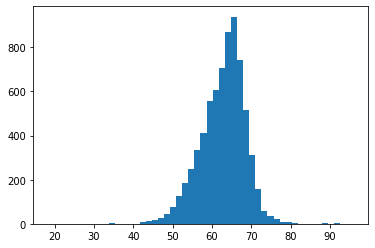


MOUTH_LEFT_CORNER_X

count    7049.000000
mean       63.851949
std         3.775175
min        23.927669
25%        62.033740
50%        63.775048
75%        65.953409
max        84.583735
Name: mouth_left_corner_x, dtype: float64

PLOT:


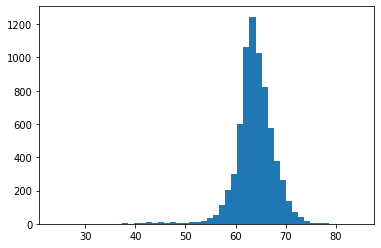


MOUTH_LEFT_CORNER_Y

count    7049.000000
mean       75.451193
std         3.948132
min        56.618000
25%        72.606981
50%        75.310472
75%        78.050933
max        94.860682
Name: mouth_left_corner_y, dtype: float64

PLOT:


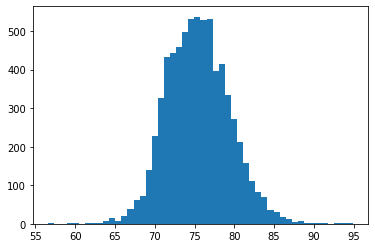


MOUTH_RIGHT_CORNER_X

count    7049.000000
mean       33.157532
std         3.398595
min         2.329657
25%        31.423832
50%        33.247044
75%        35.078026
max        73.800938
Name: mouth_right_corner_x, dtype: float64

PLOT:


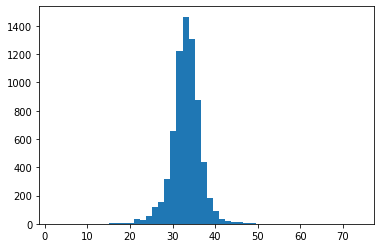


MOUTH_RIGHT_CORNER_Y

count    7049.000000
mean       75.797000
std         3.984054
min        56.631210
25%        72.945756
50%        75.792926
75%        78.499375
max        95.536850
Name: mouth_right_corner_y, dtype: float64

PLOT:


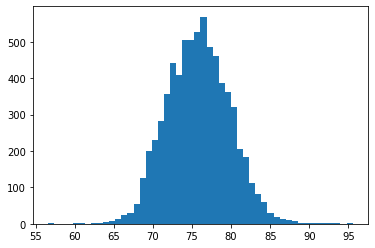


MOUTH_CENTER_TOP_LIP_X

count    7049.000000
mean       48.417368
std         3.424190
min        12.668519
25%        46.984844
50%        48.435326
75%        49.954360
max        84.034672
Name: mouth_center_top_lip_x, dtype: float64

PLOT:


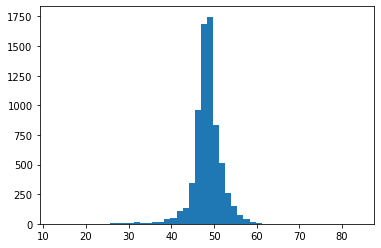


MOUTH_CENTER_TOP_LIP_Y

count    7049.000000
mean       74.351455
std         4.417997
min        56.978183
25%        71.375840
50%        74.517870
75%        77.458274
max        94.329377
Name: mouth_center_top_lip_y, dtype: float64

PLOT:


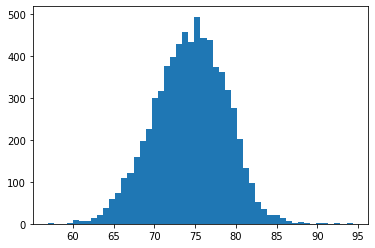


MOUTH_CENTER_BOTTOM_LIP_X

count    7049.000000
mean       48.620188
std         4.228424
min        13.074648
25%        46.652970
50%        48.650273
75%        50.701857
max        88.941925
Name: mouth_center_bottom_lip_x, dtype: float64

PLOT:


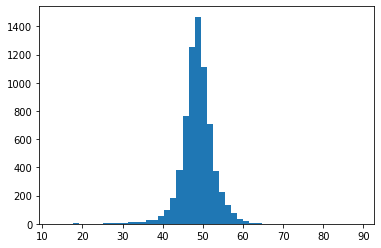


MOUTH_CENTER_BOTTOM_LIP_Y

count    7049.000000
mean       78.888541
std         5.413521
min        25.729072
25%        75.463599
50%        78.612711
75%        82.147965
max        95.728331
Name: mouth_center_bottom_lip_y, dtype: float64

PLOT:


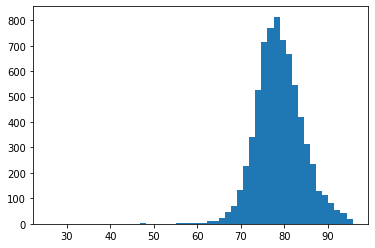

In [23]:
# after knn imputation (run KNN cell in Impute Missing Values section below)
train_knn_df = pd.DataFrame(train_knn_scaled_inverse, columns = train.drop(columns = "Image").columns)
for col in train.drop(columns = "Image"):
    print(col.upper())
    print()
    print(train_knn_df[col].describe())
    print()
    print("PLOT:")
    plt.hist(col, data = train_knn_df, bins = 50)
    plt.show()
    print()

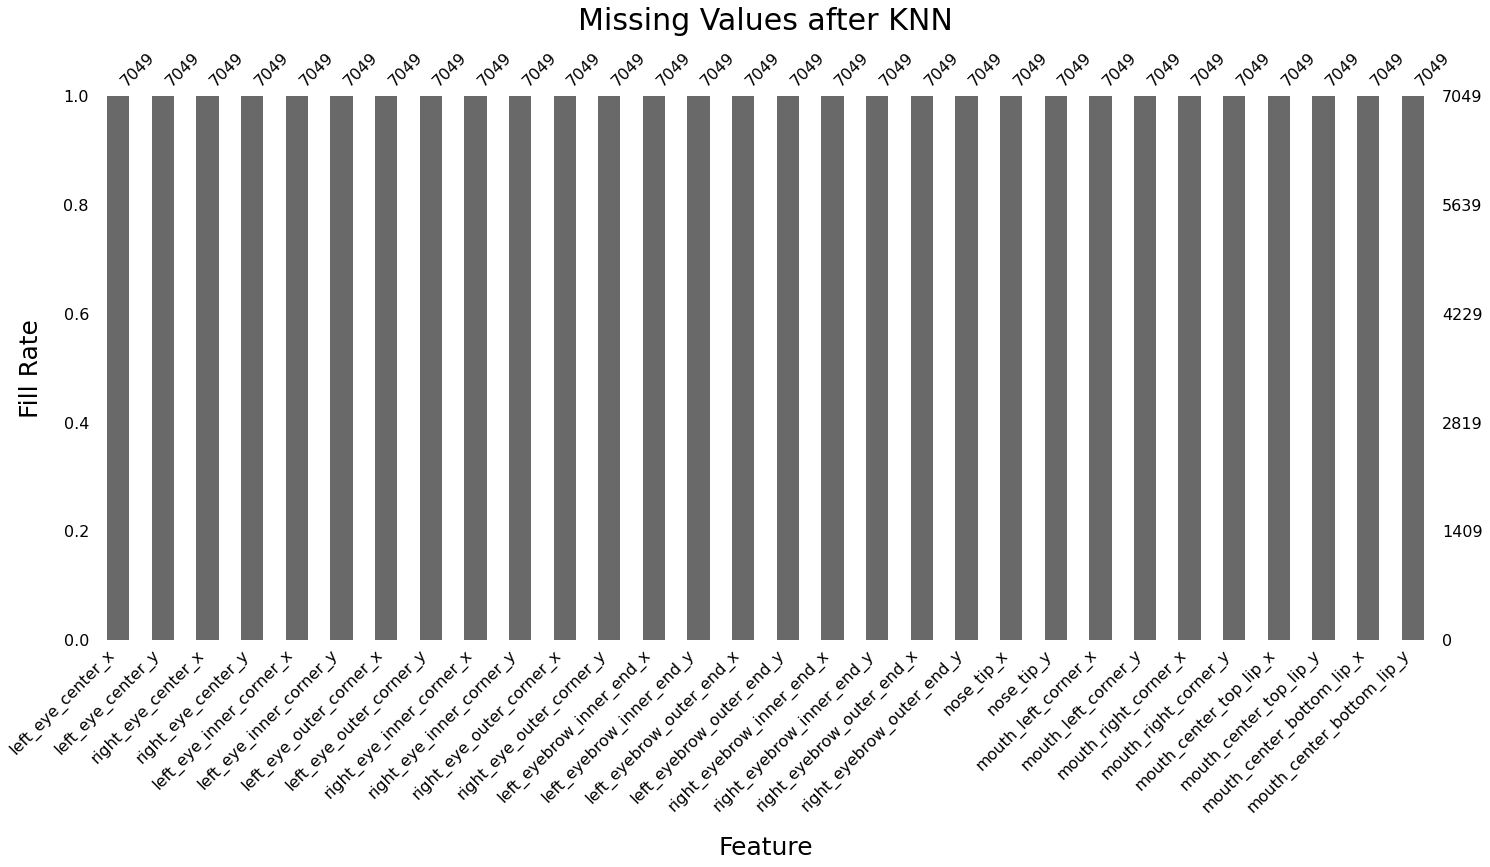

In [24]:
# confirm no more missing values (knn)
import missingno as msno
fig, ax = plt.subplots()
msno.bar(pd.DataFrame(train_knn_scaled_inverse, columns = train.drop(columns = "Image").columns))
ax.set_title("Missing Values after KNN", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

#### View Images of Each Imputation

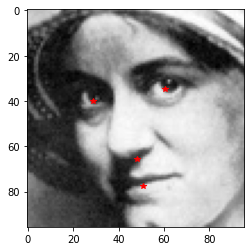

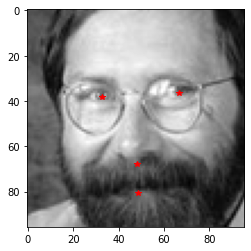

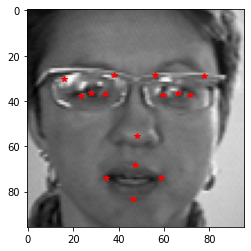

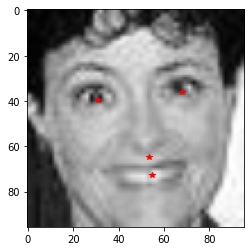

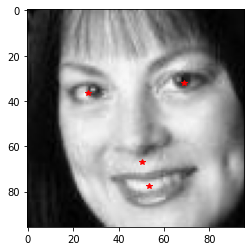

In [25]:
# check original images (for comparison)
plot_image(train_data, train_labels, 5, plot_missing = True)

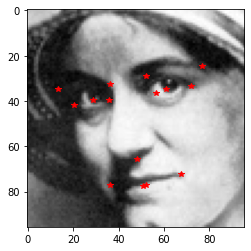

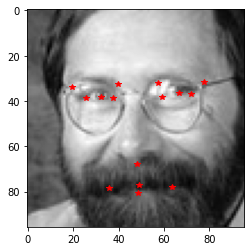

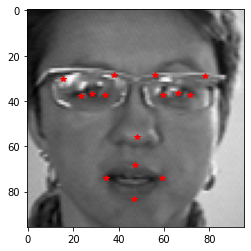

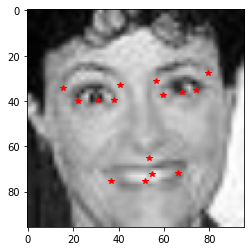

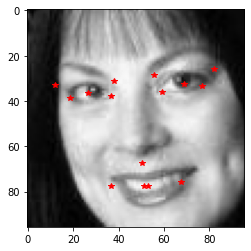

In [26]:
# check KNN-plotted images
plot_image(train_data, train_labels_knn_scaled_inverse, 5, plot_missing = True)

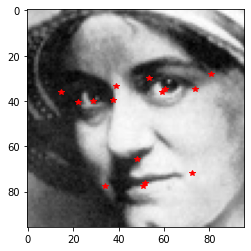

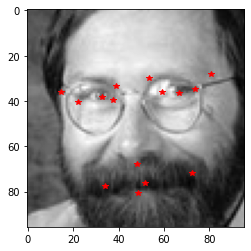

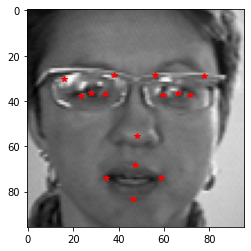

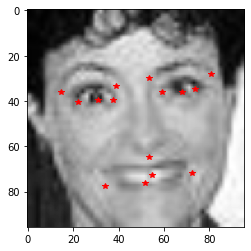

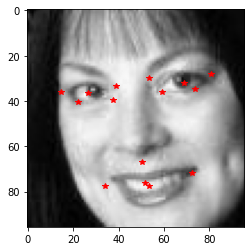

In [27]:
# check ffill-plotted images
plot_image(train_data, Y_ffill, 5, plot_missing = True)

# Modeling on the data

In [28]:
# shape tuples for reshaping the data for model
train_reshape = (5000, 9216)
train_noNA_reshape = (1200, 9216)
dev_reshape = (2049, 9216)
dev_noNA_reshape = (940, 9216)

### Baseline

In [29]:
# baseline model with NAs
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_data.reshape(train_reshape), train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data.reshape(dev_reshape), dev_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 22.12
Test score: nan
Test accuracy: 0.00683260103687644


With so many NAs in the data, the model is not able to perform.

### ffill-imputed

Modeling on the ffill-imputed dataset.

In [30]:
# ffill-imputed model
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_data.reshape(train_reshape), train_labels_ffill, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data.reshape(dev_reshape), dev_labels_ffill, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 22.19
Test score: 39864209408.0
Test accuracy: 0.6368960738182068


### KNN-imputed

Modeling on the knn-imputed dataset.

In [31]:
# KNN-imputed model
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_data.reshape(train_reshape), train_labels_knn_scaled_inverse, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data.reshape(dev_reshape), dev_labels_knn_scaled_inverse, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 26.72
Test score: 38859870208.0
Test accuracy: 0.6173743009567261


Now we will do the same model but on the cleaned noNA datasets.

### Missing Value Records Removed

In [32]:
# No NA model
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 5.32
Test score: 9835947008.0
Test accuracy: 0.7138298153877258


In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                276510    
Total params: 276,510
Trainable params: 276,510
Non-trainable params: 0
_________________________________________________________________


Because baseline performance is higher on the missing-value-removed model, and the filled values on the missing-value records are inaccurate, we will proceed with iterating on the no-na model (or maybe we will add an additional label that specifies which records had imputed values) so the model can take that into consideration.

### Adding more layers (Missing Values Removed)

In [34]:
model2 = Sequential()
model2.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model2.add(Dense(30, input_dim=30, activation='softmax'))
model2.add(Dropout(0.5))
model2.add(Dense(units=30, input_dim=30, activation='softmax'))

sgd = optimizers.SGD(lr=0.0001)
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model2.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=10, verbose=0, epochs=50) 
print ('Train time = %.2f' %(time.time() - start_time))
score2 = model2.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score2[0]) 
print('Test accuracy:', score2[1])

Train time = 3.49
Test score: 475091.03125
Test accuracy: 0.7138298153877258


No additional gain on original model.

In [35]:
model2.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                276510    
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________


### Convolutional Model Baseline Attempt (Missing Values Removed)

In [36]:
#reshape data into 2D arrays
x_train_96x96 = train_data_noNA.reshape(train_noNA_reshape).reshape(train_data_noNA.shape[0], 96, 96, 1)
x_dev_96x96 = dev_data_noNA.reshape(dev_noNA_reshape).reshape(dev_data_noNA.shape[0], 96, 96, 1)

model = Sequential() 
model.add(Conv2D(96, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model.add(Conv2D(192, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=50, input_dim=384, activation='sigmoid')) 
model.add(Dense(units=30, input_dim=50, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_96x96, train_labels_noNA, batch_size=100, epochs=5, verbose=1, validation_data=(x_dev_96x96, dev_labels_noNA))
score = model.evaluate(x_dev_96x96, dev_labels_noNA, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/5
12/12 [==============================] - 58s 5s/step - loss: 55895.6523 - accuracy: 0.5925 - val_loss: 124496.7031 - val_accuracy: 0.7138
Epoch 2/5
12/12 [==============================] - 62s 5s/step - loss: 183681.3906 - accuracy: 0.6983 - val_loss: 253536.4219 - val_accuracy: 0.7138
Epoch 3/5
12/12 [==============================] - 62s 5s/step - loss: 312993.8750 - accuracy: 0.6983 - val_loss: 382576.9062 - val_accuracy: 0.7138
Epoch 4/5
12/12 [==============================] - 66s 6s/step - loss: 441779.5312 - accuracy: 0.6983 - val_loss: 511617.5625 - val_accuracy: 0.7138
Epoch 5/5
12/12 [==============================] - 73s 6s/step - loss: 571259.3125 - accuracy: 0.6983 - val_loss: 640657.9375 - val_accuracy: 0.7138
Test score: 640658.0
Test accuracy: 0.7138298153877258


Again, no improvement in the test accuracy with CNN. No changes with batch size, epochs, or learning rate.

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 96)        960       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 192)       166080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 192)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 192)       0         
_________________________________________________________________
flatten (Flatten)            (None, 406272)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                20313650  
_________________________________________________________________
dense_7 (Dense)              (None, 30)               